# News Classification for Digital Media Platforms

### Import Libraries
In this section I install and import the libraries needed for loading the dataset, preprocessing, model training, and evaluation.

In [3]:
#Install Libraries
!pip install evaluate
!pip install gradio --quiet
!pip install transformers
!pip install huggingface_hub==0.45.0

In [4]:
#Hugging face
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline,AutoTokenizer
import gradio as gr

#visualisations
import matplotlib.pyplot as plt
import seaborn as sns

#data analysis
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import evaluate

#else
from pathlib import Path
from typing import Tuple
import torch

In [5]:
# Device configuration
device= 0 if torch.cuda.is_available() else -1
print({"device": ("cuda" if device==0 else "cpu"), "seed": 42})

{'device': 'cuda', 'seed': 42}


In [6]:
# importing data from the Hugging Face library
news_data = load_dataset("ag_news")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

#**EDA the Dataset**

### News_data structure

In [7]:
print(news_data)
print(news_data.num_columns)
print(news_data.num_rows)
print(news_data.column_names)
print(news_data['train'].features)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'train': 2, 'test': 2}
{'train': 120000, 'test': 7600}
{'train': ['text', 'label'], 'test': ['text', 'label']}
{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


this dataset contains train and test data each having a [text , label] columns the text column contains the news description and the label represents the class of that news article.
The labels are ['World', 'Sports', 'Business', 'Sci/Tech']

In [8]:
id2label = {0:'World',1:'Sports',2:'Business',3:'Sci/Tech'}
label2id = {'World':0,'Sports':1,'Business':2,'Sci/Tech':3}

* id2label represent the numrical value of each label
* label2id represent the label value of each id
- we will use those in our model




### print the first 5 rows

In [9]:
print('\tLabel\tText\n')
for i in range(5):
  print('\t',news_data['train'][i]['label'],'\t',news_data['train'][i]['text'],'\n')

	Label	Text

	 2 	 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. 

	 2 	 Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market. 

	 2 	 Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums. 

	 2 	 Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday. 

	 2 	 Oil prices soar to all-time record, posing new 

### Transfrom to Pandas data frame
we will transform it to pandas data frame to make it more flexable to explore



### the Training Data

In [10]:
train_data = news_data["train"].to_pandas()
train_data.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [12]:
train_data.describe()

,label
count,120000.000000
mean,1.500000
std,1.118039
min,0.000000
25%,0.750000
50%,1.500000
75%,2.250000
max,3.000000


**Distribution of training data across categories**

In [13]:
train_grouped=train_data.groupby(['label'])
print(train_grouped.size())

label
0    30000
1    30000
2    30000
3    30000
dtype: int64


There is equal distribution of data in each category we have 30,000 entry each

### The Testing Data

In [14]:
test_data = news_data["test"].to_pandas()
test_data.head()

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7600 non-null   object
 1   label   7600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.9+ KB


In [16]:
test_data.describe()

,label
count,7600.000000
mean,1.500000
std,1.118108
min,0.000000
25%,0.750000
50%,1.500000
75%,2.250000
max,3.000000


In [17]:
test_grouped=test_data.groupby('label')
test_grouped.agg('count')

,text
label,
0,1900
1,1900
2,1900
3,1900


There is equal distribution of data in each category we have 1900 entry each

**Visualise the distribution of data across categories in both training and sampling data**

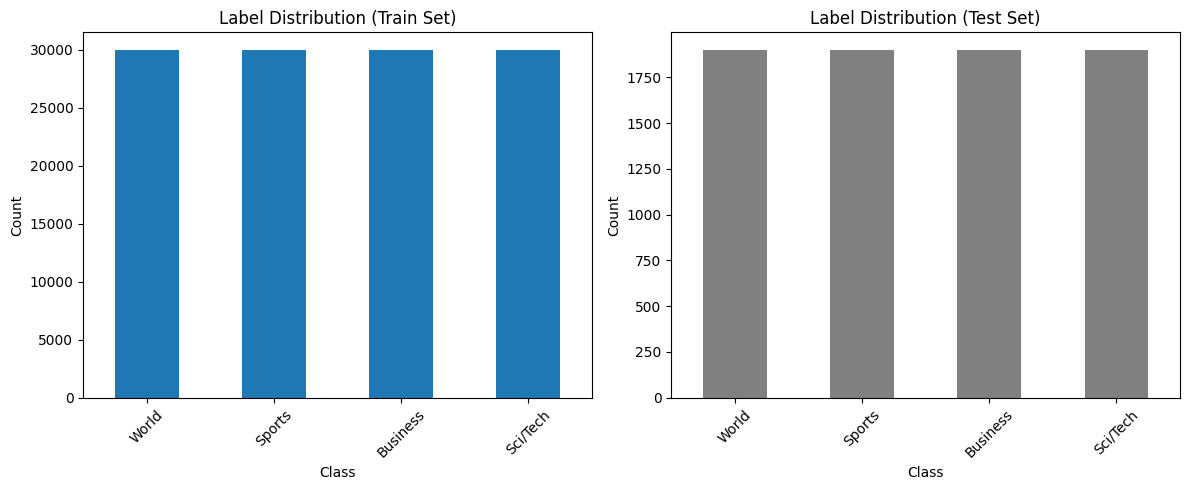

In [78]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)

label_names = ["World", "Sports", "Business", "Sci/Tech"]

train_data['label'].value_counts().sort_index().plot(kind='bar',ax=ax1)
plt.title("Label Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3], labels=label_names, rotation=45)

ax2 = plt.subplot(1, 2, 2)
test_data['label'].value_counts().sort_index().plot(kind='bar',ax=ax2, color= 'Grey')
plt.title("Label Distribution (Test Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3], labels=label_names, rotation=45)


plt.tight_layout()
plt.show()

**Distribution of text length**

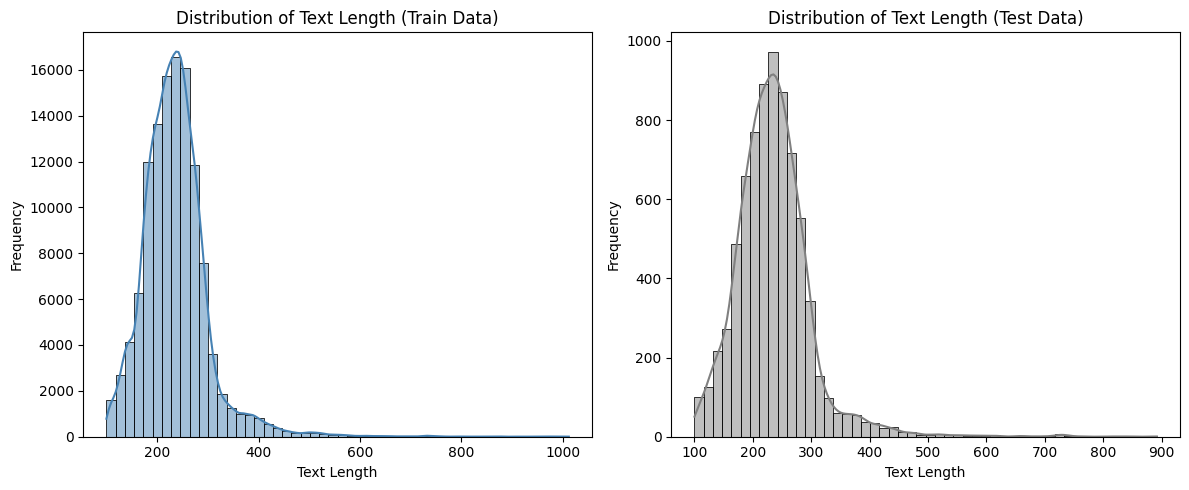

In [19]:
train_length = train_data['text'].apply(len)
test_length = test_data['text'].apply(len)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_length, bins=50, kde=True,color = 'steelblue')
plt.title('Distribution of Text Length (Train Data)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_length, bins=50, kde=True,color = 'gray')
plt.title('Distribution of Text Length (Test Data)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [20]:
print('Training data text length stats')
display(train_length.agg(['min','max','mean','median','std']))

Training data text length stats


,text
min,100.000000
max,1012.000000
mean,236.477525
median,232.000000
std,66.509741


In [21]:
print('Testing  data text length stats')
display(test_length.agg(['min','max','mean','median','std']))

Testing  data text length stats


,text
min,100.000000
max,892.000000
mean,235.299211
median,231.000000
std,65.302023


The longest text is 1,012 characters and the shortest is 100 characters.

#**Sampling**

In [80]:
train_sample = train_data.groupby('label').sample(n=250,random_state=42)
test_sample = test_data.groupby('label').sample(n=50,random_state=42)

This code samples the training data set into 250 random rows from each label (250 * 4 = 1000)
and for the test data set 50 of each label = 200

This helps us ensure equal distribution of labels when we sample.
Stratified sampling was used to preserve class balance while reducing computational cost.

In [23]:
train_sample.describe()

,label
count,1000.000000
mean,1.500000
std,1.118593
min,0.000000
25%,0.750000
50%,1.500000
75%,2.250000
max,3.000000


In [24]:
test_sample.describe()

,label
count,200.00000
mean,1.50000
std,1.12084
min,0.00000
25%,0.75000
50%,1.50000
75%,2.25000
max,3.00000


In [25]:
test_sample.head()

,text,label
7502,Sharon Predicts 'Breakthrough' in Ties With Pa...,0
5012,Captors threaten to hand hostage to Zarqawi An...,0
6818,Philippines not relieved from nature #39;s cur...,0
5500,"Arafat dead at 75 PARIS -- Yasser Arafat, who ...",0
6266,Ivory Coast violence deals economic blow Burne...,0


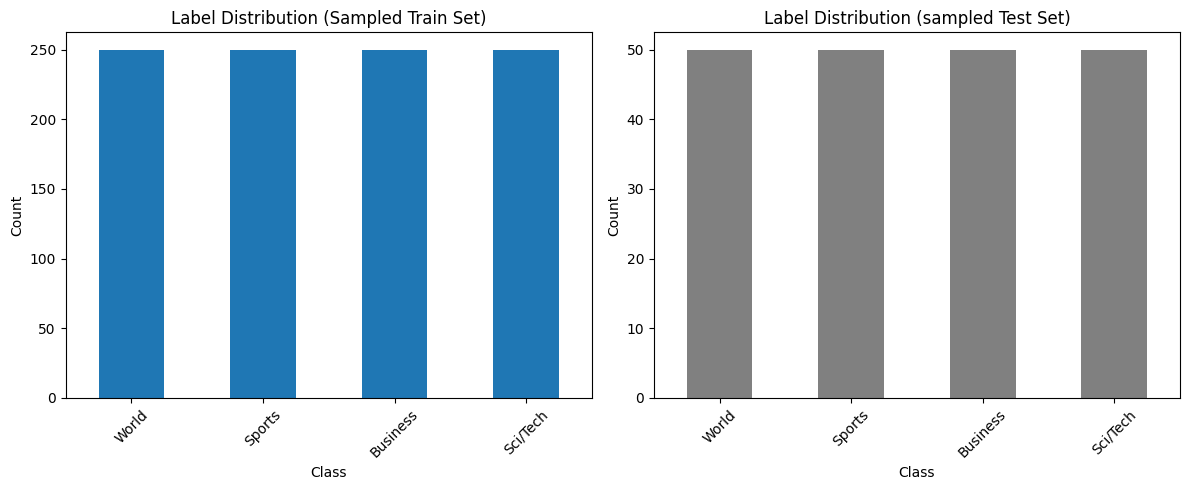

In [79]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)

label_names = ["World", "Sports", "Business", "Sci/Tech"]

train_sample['label'].value_counts().sort_index().plot(kind='bar',ax=ax1)
plt.title("Label Distribution (Sampled Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3], labels=label_names, rotation=45)

ax2 = plt.subplot(1, 2, 2)
test_sample['label'].value_counts().sort_index().plot(kind='bar',ax=ax2, color= 'Grey')
plt.title("Label Distribution (sampled Test Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3], labels=label_names, rotation=45)


plt.tight_layout()
plt.show()

These visualisations shows the distribution of labels in the sampled train and test data frames

# **Tokenise the sample data**
we tokenize to transform text to numerical values the computer can understand and train on

In [28]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") # we will use distilbert-base-uncased transformer therefore we will use it for tokenization

def tokenize_function(entry):
  return tokenizer( # This tells the Hugging Face tokenizer to convert the text into:input_ids And attention_mask
        entry["text"],
        truncation=True, # If a sentence is too long, cut it to fit the max length. to prevent errors
        max_length=128, # This sets the maximum sequence length. truncated to 128 tokens if too long , padded to 128 tokens if too short
        padding="max_length" # If a sentence is too short, add padding zeros until it reaches max_length.
    )

ERROR: Ignored the following yanked versions: 0.8.0, 0.9.0.dev0, 0.9.0rc0, 0.16.1, 0.26.4, 0.31.3
ERROR: Could not find a version that satisfies the requirement huggingface_hub==0.45.0 (from versions: 0.0.1, 0.0.2, 0.0.3rc1, 0.0.3rc2, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.11, 0.0.12, 0.0.13, 0.0.14, 0.0.15, 0.0.16, 0.0.17, 0.0.18, 0.0.19, 0.1.0, 0.1.1, 0.1.2, 0.2.0, 0.2.1, 0.4.0, 0.5.0, 0.5.1, 0.6.0rc0, 0.6.0, 0.7.0rc0, 0.7.0, 0.8.0rc0, 0.8.0rc1, 0.8.0rc2, 0.8.0rc3, 0.8.0rc4, 0.8.1, 0.9.0rc2, 0.9.0rc3, 0.9.0, 0.9.1, 0.10.0rc0, 0.10.0rc1, 0.10.0rc3, 0.10.0, 0.10.1, 0.11.0rc0, 0.11.0rc1, 0.11.0, 0.11.1, 0.12.0rc0, 0.12.0, 0.12.1, 0.13.0rc0, 0.13.0rc1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.13.4, 0.14.0rc0, 0.14.0rc1, 0.14.0, 0.14.1, 0.15.0rc0, 0.15.0, 0.15.1, 0.16.0rc0, 0.16.2, 0.16.3, 0.16.4, 0.17.0rc0, 0.17.0, 0.17.1, 0.17.2, 0.17.3, 0.18.0rc0, 0.18.0, 0.19.0rc0, 0.19.0, 0.19.1, 0.19.2, 0.19.3, 0.19.4, 0.20.0rc0, 0.20.0rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.21.0rc0, 0.21.0, 0.21.1,

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The tokenize_function takes a row from the data set and put it through the tokenizer to be returned as input_id and attention_mask



In [29]:
# maping the function on our data set to tokenize everything
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_sample)# transfrom the data frame into a dataset
test_dataset = Dataset.from_pandas(test_sample)# transfrom the data frame into a dataset


tokenized_train = train_dataset.map(tokenize_function, batched=True) # apply the function in all rows
tokenized_test = test_dataset.map(tokenize_function, batched=True) # apply the function in all rows

#you set batched=True  HuggingFace will call your function with a batch of rows, not one row This makes tokenisation much faster.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

in this code we first transformed back the data frames into datasets

next we applied the tokenize_function by mapping it on the data sets

**view how the tokenisation look(example)**

In [30]:
print('input_ids:',tokenized_train[0]['input_ids']) # list of ids representing  the text turned into numbers
print('attention_mask:',tokenized_train[0]['attention_mask']) # 1 -> real token or 0-> padding token
print('label:',tokenized_train[0]['label']) #label is numerical

input_ids: [101, 5747, 1024, 16406, 1997, 5924, 3789, 1999, 4797, 1006, 9706, 1007, 9706, 1011, 2343, 5747, 4161, 5958, 2008, 5571, 1997, 14303, 9861, 2031, 3459, 4797, 2006, 1996, 5969, 2602, 1010, 1998, 7420, 2008, 2151, 2647, 1011, 13630, 14790, 2006, 4238, 1005, 1055, 4517, 2565, 2442, 5676, 1996, 2088, 2064, 20410, 13503, 1005, 1055, 12646, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
label: 0


# **Transformer**

Training the LLM model by fine-tuning it using our training data

In [31]:
# Setup model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert-base-uncased",
    num_labels=4, # number of labels we have
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    )

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Create a folder to save models training and checkpoints**

In [32]:
# Create models directory
path = Path("models")
path.mkdir(exist_ok=True)

# Create model save name
model_name = "news_classification_file"

save_dir = Path(path, model_name)

save_dir

PosixPath('models/news_classification_file')

**Create training arguments to feed in the model**

In [34]:
# Create training arguments
arguments = TrainingArguments(
    output_dir=save_dir, # where to save the output
    learning_rate=2e-4,# hyperparameter Value of the initial learning rate to use during training
    per_device_train_batch_size=32, # the model will look at 32 samples at a time during training
    per_device_eval_batch_size=32, # the model will look at 32 samples at a time during evaluation
    num_train_epochs=10, # Number of times to pass over the data to try and learn patterns. the model will do 10 full passes of the training data (make it smaller for the full data set training)
    eval_strategy="epoch", # the model will be evaluated every epoch.
    save_strategy="epoch",# checkpoint will be saved every epoch
    save_total_limit=3, # total number of saves are the 3 most recent as well as the best performing checkpoint
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # results will be logged as outputs every epoch
    report_to="none",
)

**Create an evaluation function to include in our trainer**
in this case we will use accuracy to evaluate the results
by comparing predicted label with the actual label

In [35]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1": f1}

**Creat the trainer to train it on the tokenized training data using our model and test it on the tokenized test data then evaluate the predction using the accuracy method**

I now fine-tune DistilBERT on the sampled training set for 10 epochs, evaluating on the sampled test set after each epoch

In [36]:
# Setup Trainer
trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-274921401.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


train the trainer

In [37]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.598700,0.468643,0.850000,0.852629
2,0.299100,0.344156,0.880000,0.879551
3,0.149700,0.503623,0.870000,0.872527
4,0.076400,0.518678,0.885000,0.884932
5,0.067600,0.565971,0.880000,0.879739
6,0.045300,0.508025,0.895000,0.895041
7,0.019600,0.521662,0.900000,0.900269
8,0.019200,0.493043,0.895000,0.895354
9,0.007100,0.529315,0.900000,0.900465
10,0.002400,0.534061,0.900000,0.900465


In [38]:
print(results.metrics)

{'train_runtime': 265.8815, 'train_samples_per_second': 37.611, 'train_steps_per_second': 1.204, 'total_flos': 331180308480000.0, 'train_loss': 0.12852036610711365, 'epoch': 10.0}


print the results of the training

In [39]:
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 265.8815
train_samples_per_second: 37.611
train_steps_per_second: 1.204
total_flos: 331180308480000.0
train_loss: 0.12852036610711365
epoch: 10.0


**Save the results (to the directory)**

In [40]:
trainer.save_model(output_dir=save_dir)

**The best checkpoint**

In [41]:
best_ckpt = trainer.state.best_model_checkpoint
print("Best checkpoint is:", best_ckpt)

Best checkpoint is: models/news_classification_file/checkpoint-64


 Reloads the best checkpoint and evaluates it

In [42]:
best_ckpt = trainer.state.best_model_checkpoint

best_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)

best_trainer = Trainer(
    model=best_model,
    args=arguments,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

eval_results = best_trainer.evaluate()
for key, value in eval_results.items():
    print(f"{key}: {value}")


eval_loss: 0.3441561162471771
eval_model_preparation_time: 0.0013
eval_accuracy: 0.88
eval_f1: 0.8795514060743682
eval_runtime: 0.7219
eval_samples_per_second: 277.047
eval_steps_per_second: 9.697


#**Evaluation**

### Testing the model from outside the data set

In [43]:
news_classifier = pipeline(task="text-classification",
                                    model='models/news_classification_file',
                                    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
                                    top_k=1,
                                    batch_size=32)

news_classifier("the king visted the prince")

Device set to use cuda


[[{'label': 'World', 'score': 0.47659042477607727}]]

### testing data prediction

In [44]:
# Perform predictions on the test set
test_predictions = trainer.predict(tokenized_test)
prediction_results = test_predictions.predictions
# evaluate the prediction
pred_evaluation = test_predictions.metrics

print(f"prediction in the test data")
pred_evaluation

prediction in the test data


{'test_loss': 0.3441561162471771,
 'test_accuracy': 0.88,
 'test_f1': 0.8795514060743682,
 'test_runtime': 0.6845,
 'test_samples_per_second': 292.181,
 'test_steps_per_second': 10.226}

In [45]:
# 1. Get prediction probabilities
pred_probs = torch.softmax(torch.tensor(prediction_results), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = test_dataset["label"]

### Evaluation Metrice of the testing data set predictions

In [46]:

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")

print("overall evaluation metrice ")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


overall evaluation metrice 
Accuracy:  0.8800
Precision: 0.8890
Recall:    0.8800
F1-score:  0.8796


### Per class evaluation & Confusion matrix

In [47]:
#per-class evaluation
print("per category evaluation metrice")
print(classification_report(true_labels, pred_labels, digits=4))

per category evaluation metrice
              precision    recall  f1-score   support

           0     0.9487    0.7400    0.8315        50
           1     0.9792    0.9400    0.9592        50
           2     0.8036    0.9000    0.8491        50
           3     0.8246    0.9400    0.8785        50

    accuracy                         0.8800       200
   macro avg     0.8890    0.8800    0.8796       200
weighted avg     0.8890    0.8800    0.8796       200



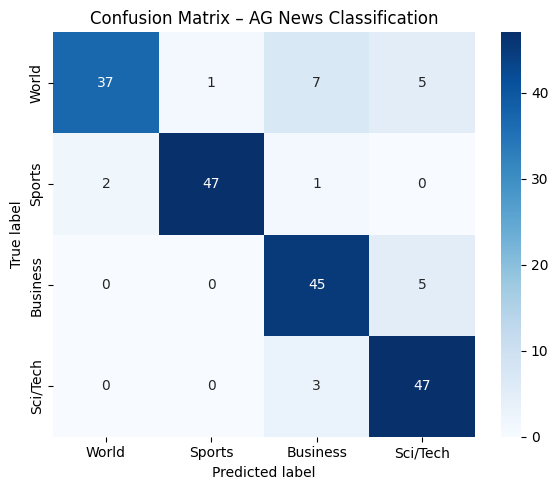

In [48]:
labels = ["World", "Sports", "Business", "Sci/Tech"]

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – AG News Classification")
plt.tight_layout()
plt.show()

sports was the most accurately predicted of all classes

**F1-score per category visualisation**

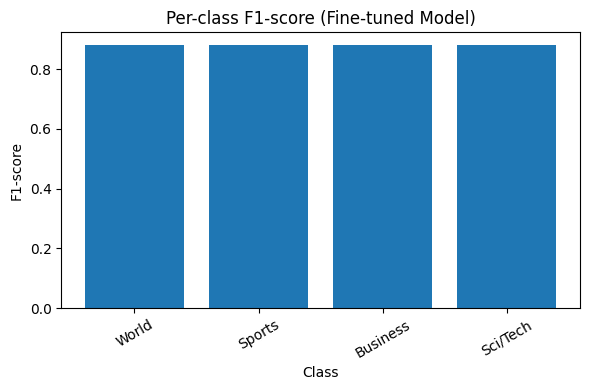

In [49]:
# Plot F1 per class
plt.figure(figsize=(6, 4))
x = np.arange(len(labels))
plt.bar(x, f1)
plt.xticks(x, labels, rotation=30)
plt.ylabel("F1-score")
plt.xlabel("Class")
plt.title("Per-class F1-score (Fine-tuned Model)")
plt.tight_layout()
plt.show()



###The 10 most misclassified

In [50]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": test_dataset["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})
# The 10 most misclassified
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
24,Italian PM #39;s transplant confirmed After da...,0,3,0.401769
42,Kerry Challenges Bush Record on Issues DETROIT...,0,2,0.422637
147,No ticket matched all four numbers and the Meg...,2,2,0.440842
10,EU Unveils Plans for New Banana Tariffs (AP) A...,0,0,0.468512
61,Bryant Jury Selection Behind Closed Doors (AP)...,1,0,0.493722
2,Philippines not relieved from nature #39;s cur...,0,3,0.495317
195,'Cities in crisis' leaders warn World leaders ...,3,3,0.500853
25,Renault unveils investment plan for Asian hub ...,0,0,0.508946
175,Coping With the Common Cold By Karen Pallarito...,3,3,0.512052
36,Pacifist Japan boosts #39;self-defence #39; m...,0,2,0.563124


### Metrics per epoch
During training, the HuggingFace Trainer keeps a history log of everything that happened at each epoch

1- Splits it into training metrics and evaluation metrics

2- Turns them into DataFrames

3- Plots training loss vs evaluation loss

In [81]:
# Get training history
history = trainer.state.log_history
history_metrics = history[:-1] # get everything except the training time metrics

history_metrics[:4]

[{'loss': 0.5987,
  'grad_norm': 10.997932434082031,
  'learning_rate': 0.000180625,
  'epoch': 1.0,
  'step': 32},
 {'eval_loss': 0.4686433672904968,
  'eval_accuracy': 0.85,
  'eval_f1': 0.8526291803788371,
  'eval_runtime': 0.9266,
  'eval_samples_per_second': 215.831,
  'eval_steps_per_second': 7.554,
  'epoch': 1.0,
  'step': 32},
 {'loss': 0.2991,
  'grad_norm': 1.069782018661499,
  'learning_rate': 0.00016062500000000001,
  'epoch': 2.0,
  'step': 64},
 {'eval_loss': 0.3441561162471771,
  'eval_accuracy': 0.88,
  'eval_f1': 0.8795514060743682,
  'eval_runtime': 0.9201,
  'eval_samples_per_second': 217.378,
  'eval_steps_per_second': 7.608,
  'epoch': 2.0,
  'step': 64}]

In [52]:
# separate into training and evaluation metrics
training_history = []
evaluation_history = []

for item in history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item then it is an evaluation
    if any("eval" in item for item in item_keys):
        evaluation_history.append(item)
    else:
        training_history.append(item)


# turn it into pandas DataFrames
training_history_df = pd.DataFrame(training_history)
eval_history_df = pd.DataFrame(evaluation_history)

display(training_history_df.head() )

display(eval_history_df.head())

,loss,grad_norm,learning_rate,epoch,step
0,0.5987,10.997932,0.000181,1.0,32
1,0.2991,1.069782,0.000161,2.0,64
2,0.1497,0.107735,0.000141,3.0,96
3,0.0764,0.126489,0.000121,4.0,128
4,0.0676,0.196200,0.000101,5.0,160


,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.468643,0.850,0.852629,0.9266,215.831,7.554,1.0,32
1,0.344156,0.880,0.879551,0.9201,217.378,7.608,2.0,64
2,0.503623,0.870,0.872527,0.9755,205.030,7.176,3.0,96
3,0.518678,0.885,0.884932,0.8086,247.351,8.657,4.0,128
4,0.565971,0.880,0.879739,0.7749,258.105,9.034,5.0,160


### training and evaluation loss over epoch


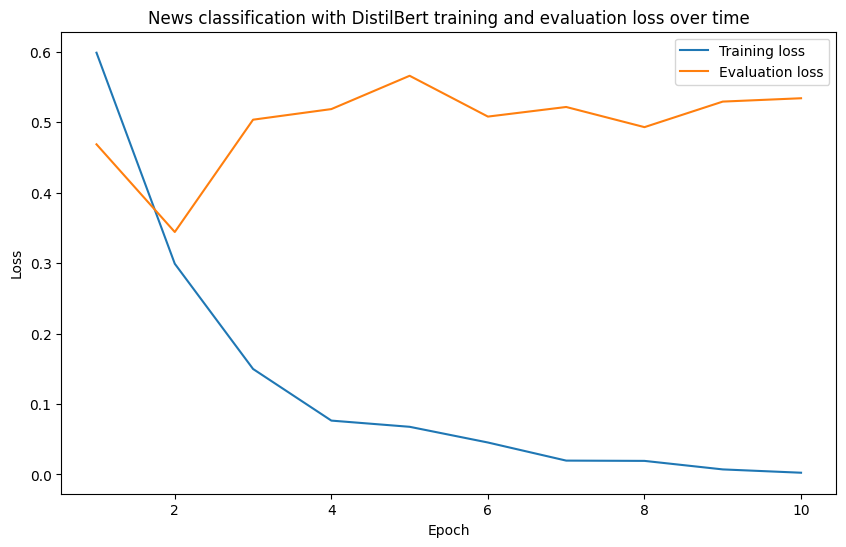

In [53]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(training_history_df["epoch"], training_history_df["loss"], label="Training loss")
plt.plot(eval_history_df["epoch"], eval_history_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("News classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

### Compare fine tuned and not

In [54]:
# Create the base model
base_model_name = "distilbert-base-uncased"

base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=4
)

base_args = TrainingArguments(
    output_dir=Path(Path('base'), "base_results") ,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch", # the model will be evaluated every epoch.
    save_strategy="epoch",# checkpoint will be saved every epoch
    save_total_limit=3, # total number of saves are the 3 most recent as well as the best performing checkpoint
    use_cpu=False,
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # results will be logged as outputs every epoch
    report_to="none",
    do_train=False,
    do_eval=True
)


base_trainer = Trainer(
    model=base_model,
    args=base_args,
    eval_dataset= tokenized_test
)
# Use the base model to predict
base_pred_output = base_trainer.predict(tokenized_test)
base_y_pred = np.argmax(base_pred_output.predictions, axis=-1)
#Evaluate the base model
base_acc = accuracy_score(true_labels, base_y_pred)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(
    true_labels, base_y_pred, average="weighted")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
# Compare the evaluations of each model
metrics_data = {
    "Model": ["Base", "Fine-tuned"],
    "Accuracy": [base_acc, accuracy],
    "F1-score": [base_f1, f1]
}
metrics_df = pd.DataFrame(metrics_data)

print(metrics_df.to_markdown(index=False))

| Model      |   Accuracy |   F1-score |
|:-----------|-----------:|-----------:|
| Base       |      0.235 |   0.174349 |
| Fine-tuned |      0.88  |   0.879551 |


**visualisation of the accuracy: Base vs Fine-tuned Model**

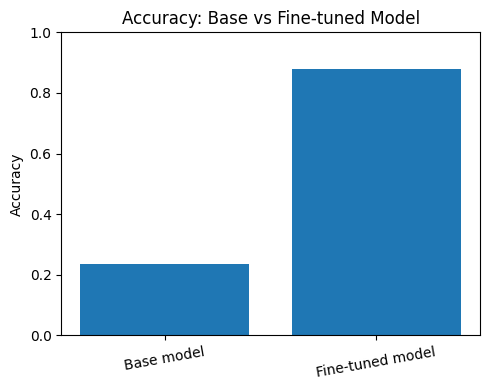

In [56]:
# Bar chart comparison
labels = ["Base model", "Fine-tuned model"]
acc_values = [base_acc, accuracy]

plt.figure(figsize=(5, 4))
x = np.arange(len(labels))
plt.bar(x, acc_values)
plt.xticks(x, labels, rotation=10)
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.title("Accuracy: Base vs Fine-tuned Model")
plt.tight_layout()
plt.show()


# Connection to Hugging Face
Save our model to the Hugging Face Hub


In [57]:
from google.colab import userdata

# This will be public, since we set hub_private_repo=False in our TrainingArguments
model_url = trainer.push_to_hub(
    commit_message="Pushing the news classification model ",
    token= userdata.get('hugging_face_token') # get the token from the secrets in google colab

)
print(f"The model is uploaded to hugging face and you can access it from: {model_url}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...on_file/model.safetensors:   3%|2         | 6.85MB /  268MB            

  ...on_file/training_args.bin:   1%|          |  57.0B / 5.84kB            

The model is uploaded to hugging face and you can access it from: https://huggingface.co/kozy9/news_classification_file/tree/main/


**Trying to use the model by importing it from hugging face**

In [58]:
from transformers import pipeline
import torch
news_classifier = pipeline(task="text-classification",
                                    model='kozy9/news_classification_file',
                                    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
                                    top_k=1,
                                    batch_size=32)

news_classifier("the blue team scored a goal")

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[[{'label': 'Sports', 'score': 0.9897884726524353}]]

# Creating an Interface

creating a gradio link to make a web based interface to use the model

In [67]:
def chat_interface(user_text):
  if not user_text.strip():
    return "Please type something."
  return news_classifier(user_text)

In [68]:
demo = gr.Interface(
fn=chat_interface,
description = 'This is news classification bot, provide the description of the news article and it will return the category of it',
inputs=gr.Textbox(lines=10, label="News description"),
outputs=gr.Textbox(lines=1, label="News category"),
title="News description classification"
)

In [69]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a20d226ae6d82ba113.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
